In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import glob
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, wasserstein_distance
from nltk import Tree
from scipy.stats import gaussian_kde
import numpy as np
from scipy.signal import find_peaks
from collections import defaultdict
from pprint import pprint
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

# 1. get the data

In [11]:
# Initialize a dictionary to store (tree, score) pairs for each file
tree_score_data_0 = {}

# List of your JSON files
json_files = [
    "/content/drive/MyDrive/parse/0.0.json",
    "/content/drive/MyDrive/parse/0.1.json",
    "/content/drive/MyDrive/parse/0.2.json",
    "/content/drive/MyDrive/parse/0.3.json"
]

# Iterate through files and extract data
for json_file in json_files:
    file_name = json_file.split("/")[-1]  # Get the file name
    print(f"Processing file: {file_name}...")
    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            data = json.load(file)
            if isinstance(data, list) and 'trees' in data[0]:  # Ensure correct data format
                tree_score_data_0[file_name] = [
                    (entry['structure'], entry['score']) for entry in data[0]['trees']
                ]
                print(f"Successfully extracted {len(tree_score_data_0[file_name])} (tree, score) pairs from {file_name}.")
            else:
                print(f"No 'trees' found in {file_name}.")
                tree_score_data_0[file_name] = []
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        tree_score_data_0[file_name] = []


Processing file: 0.0.json...
Successfully extracted 113 (tree, score) pairs from 0.0.json.
Processing file: 0.1.json...
Successfully extracted 113 (tree, score) pairs from 0.1.json.
Processing file: 0.2.json...
Successfully extracted 113 (tree, score) pairs from 0.2.json.
Processing file: 0.3.json...
Successfully extracted 113 (tree, score) pairs from 0.3.json.


In [ ]:
# Define a function to print the textual format of a tree
def print_tree(tree_str):
    """
    Print the formatted structure of a tree from its string representation.
    :param tree_str: String representation of the tree
    """
    tree = Tree.fromstring(tree_str)
    print("\nFormatted Tree Structure:")
    tree.pretty_print()  # Print the formatted tree
    print("\n")

# 2. ambigous *sentences*

## 2.1 PP Attachment Ambiguity

### 2.1.1 an enranged cow injured a farmer with an ax

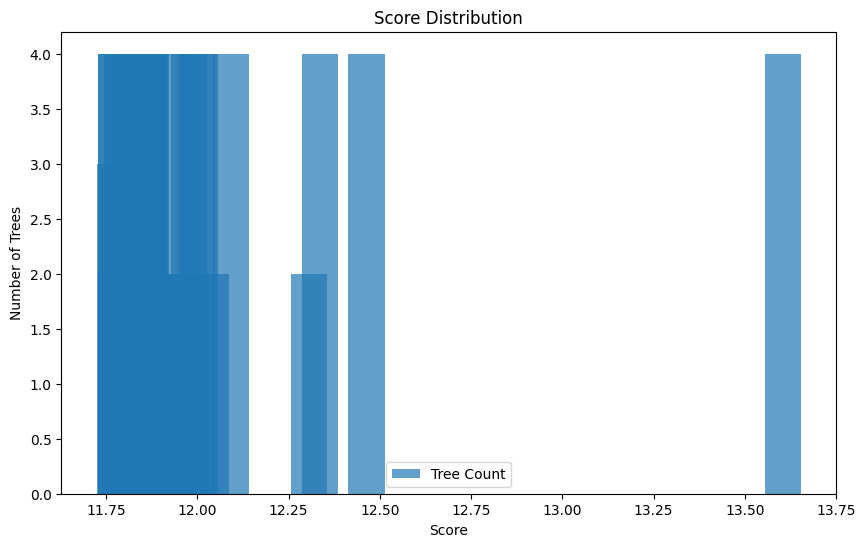

In [ ]:
# Plot the distribution for a specific file
file_to_plot = "0.0.json"
trees_scores = tree_score_data_0.get(file_to_plot)

# 1. Group tree structures by score
def group_trees_by_score(trees_scores):
    """
    Group trees based on their scores.
    :param trees_scores: List of (tree, score) tuples
    :return: Dictionary with scores as keys and lists of trees as values
    """
    grouped_trees = defaultdict(list)
    for tree, score in trees_scores:
        grouped_trees[score].append(tree)
    return grouped_trees

# 2. Compare whether all trees in a group are identical
def compare_trees_within_group(trees):
    """
    Check if all trees in the group are identical.
    :param trees: List of tree structures
    :return: True if all trees are identical, False otherwise
    """
    return all(tree == trees[0] for tree in trees)

# 3. Visualize score distribution
def plot_score_distribution(grouped_trees):
    """
    Plot the distribution of scores based on the number of trees.
    :param grouped_trees: Dictionary with scores as keys and lists of trees as values
    """
    scores = list(grouped_trees.keys())
    counts = [len(trees) for trees in grouped_trees.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(scores, counts, width=0.1, alpha=0.7, label='Tree Count')
    plt.xlabel("Score")
    plt.ylabel("Number of Trees")
    plt.title("Score Distribution")
    plt.legend()
    plt.show()

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Step 1: Group tree structures by score
def group_trees_by_score(trees_scores):
    """
    Group trees based on their scores.
    :param trees_scores: List of (tree, score) pairs
    :return: Dictionary with scores as keys and lists of trees as values
    """
    grouped_trees = defaultdict(list)
    for tree, score in trees_scores:
        grouped_trees[score].append(tree)
    return grouped_trees

# Step 2: Get the top score groups
def get_top_score_groups(grouped_trees, top_k=3):
    """
    Retrieve the top k groups with the highest scores.
    :param grouped_trees: Dictionary of scores -> trees
    :param top_k: Number of top groups to retrieve
    :return: Sorted list of top score groups
    """
    sorted_groups = sorted(grouped_trees.items(), key=lambda x: -x[0])  # Sort by score in descending order
    return sorted_groups[:top_k]

# Step 3: Compare tree structures within a group
def compare_trees_within_group(trees):
    """
    Check if all trees in the group are identical.
    :param trees: List of trees in a group
    :return: Boolean indicating whether all trees are identical
    """
    return all(tree == trees[0] for tree in trees)

# Extract groups
grouped_trees = group_trees_by_score(trees_scores)

# Get the top scoring groups
top_k = 4  # View the top 4 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Step 4: Print
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and print the tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])


Score: 13.603996, Number of Trees: 4
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
                          S                             
        __________________|________                      
       |                           VP                   
       |             ______________|__________           
       |            |         |               PP        
       |            |         |           ____|___       
       NP           |         NP         |        NP    
  _____|______      |      ___|____      |     ___|___   
 DT   VBN     NN   VBN    DT       NN    IN   DT      NN
 |     |      |     |     |        |     |    |       |  
 an enranged cow injured  a      farmer with  an      ax




Score: 12.463457, Number of Trees: 4
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
                          S                             
        __________________|________                      
       |                           VP 

### 2.1.2 he sightread the piece with a lot of F naturals



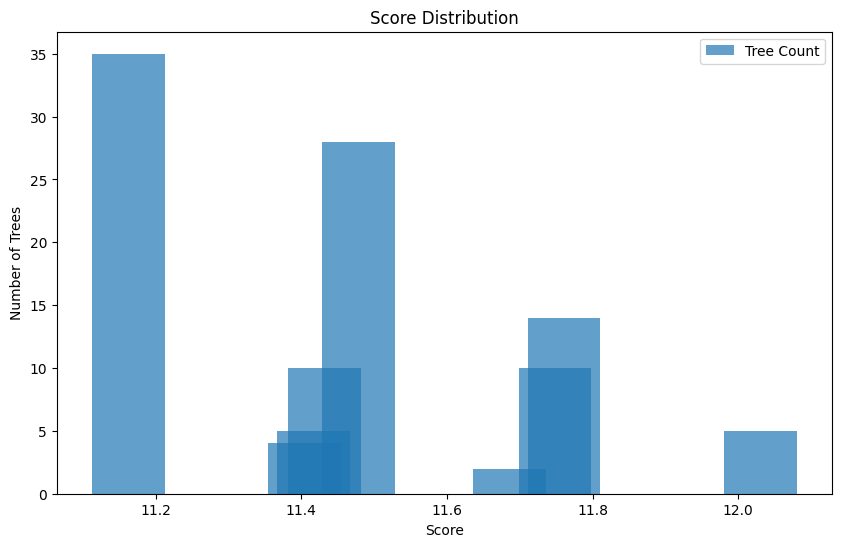

In [ ]:
# Plot the distribution for a specific file
file_to_plot = "0.1.json"
trees_scores = tree_score_data_0.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Extract groups
grouped_trees = group_trees_by_score(trees_scores)

# Get the top scoring groups
top_k = 9  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Step 4: Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and print the tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree


Score: 12.030312, Number of Trees: 5
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
                             S                                   
  ___________________________|____________                        
 |      |          |                      PP                     
 |      |          |          ____________|___                    
 |      |          |         |                NP                 
 |      |          |         |         _______|___                
 |      |          |         |        |           PP             
 |      |          |         |        |        ___|___            
 NP     |          NP        |        NP      |       NP         
 |      |       ___|____     |     ___|___    |    ___|_____      
PRP    VBD     DT       NN   IN   DT      NN  IN NNP       NNS   
 |      |      |        |    |    |       |   |   |         |     
 he sightread the     piece with  a      lot  of  F      naturals




Score: 11.760736, Number o

## 2.2 Compound noun attachment ambiguity

### 2.2.1 The hospital is being sued by six foot doctors.

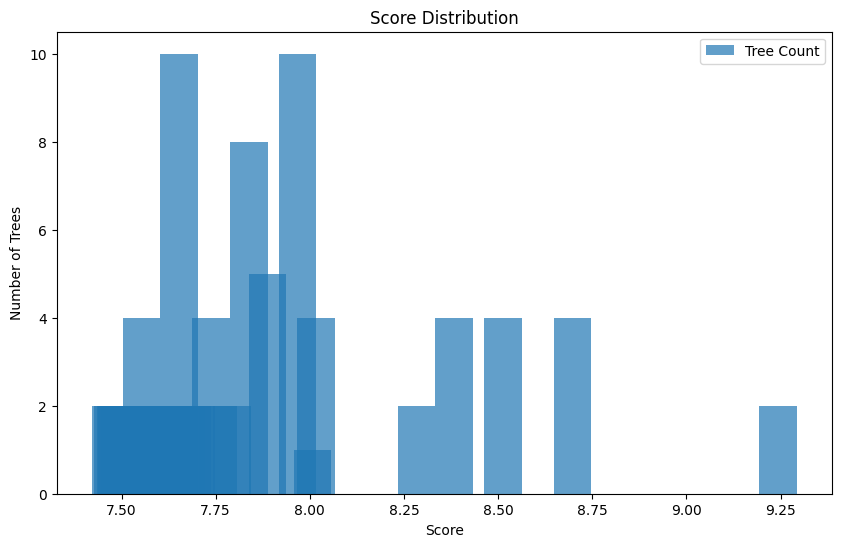

In [ ]:
# Plot the distribution for a specific file
file_to_plot = "0.2.json"
trees_scores = tree_score_data_0.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Extract groups
grouped_trees = group_trees_by_score(trees_scores)

# Get the top scoring groups
top_k = 7  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Step 4: Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and print the tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree


Score: 9.242778, Number of Trees: 2
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
           S                                            
      _____|___________                                  
     |                 VP                               
     |             ____|_________                        
     |            |              VP                     
     |            |     _________|___                    
     |            |    |             VP                 
     |            |    |     ________|___                
     |            |    |    |            PP             
     |            |    |    |     _______|___            
     NP           |    |    |    |           NP         
  ___|_____       |    |    |    |    _______|______     
 DT        NN    VBZ  VBG  VBN   IN  CD      NN    NNS  
 |         |      |    |    |    |   |       |      |    
the     hospital  is being sued  by six     foot doctors




Score: 8.697968, Number of Tr

## 2.3 Subordinate clause

### 2.3.1 The professor said on Monday he would give an exam.

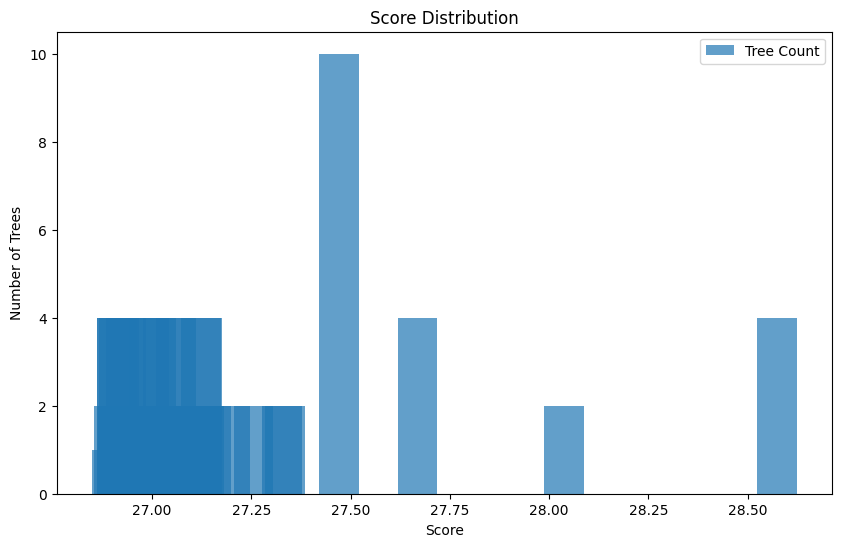

In [ ]:
# Plot the distribution for a specific file
file_to_plot = "0.3.json"
trees_scores = tree_score_data_0.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Extract groups
grouped_trees = group_trees_by_score(trees_scores)

# Get the top scoring groups
top_k = 2  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Step 4: Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and print the tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree


Score: 28.573153, Number of Trees: 4
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
            S                                                                   
      ______|___________                                                         
     |                  VP                                                      
     |              ____|___________________                                     
     |             |        |              SBAR                                 
     |             |        |           ____|_________                           
     |             |        |          |              VP                        
     |             |        |          |     _________|_______                   
     |             |        |          |    |                 VP                
     |             |        |          |    |     ____________|________          
     |             |        PP         |    |    |        |            PP      

# 3. ambigous sentences that cannot be interpreted by parsing structure

In [ ]:
# Initialize a dictionary to store (tree, score) pairs for each file
tree_score_data = {}

# List of your JSON files
json_files = [
    "/content/drive/MyDrive/parse/1.0.json",
    "/content/drive/MyDrive/parse/1.1.json",
    "/content/drive/MyDrive/parse/1.2.json",
    "/content/drive/MyDrive/parse/1.3.json",
    "/content/drive/MyDrive/parse/1.4.json"
]

# Iterate through files and extract data
for json_file in json_files:
    file_name = json_file.split("/")[-1]  # Get the file name
    print(f"Processing file: {file_name}...")
    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            data = json.load(file)
            if isinstance(data, list) and 'trees' in data[0]:  # Ensure correct data format
                tree_score_data[file_name] = [
                    (entry['structure'], entry['score']) for entry in data[0]['trees']
                ]
                print(f"Successfully extracted {len(tree_score_data[file_name])} (tree, score) pairs from {file_name}.")
            else:
                print(f"No 'trees' found in {file_name}.")
                tree_score_data[file_name] = []
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        tree_score_data[file_name] = []

Processing file: 1.0.json...
Successfully extracted 113 (tree, score) pairs from 1.0.json.
Processing file: 1.1.json...
Successfully extracted 113 (tree, score) pairs from 1.1.json.
Processing file: 1.2.json...
Successfully extracted 113 (tree, score) pairs from 1.2.json.
Processing file: 1.3.json...
Successfully extracted 113 (tree, score) pairs from 1.3.json.
Processing file: 1.4.json...
Successfully extracted 113 (tree, score) pairs from 1.4.json.


## 3.0 even though he was failing, he refused to give up

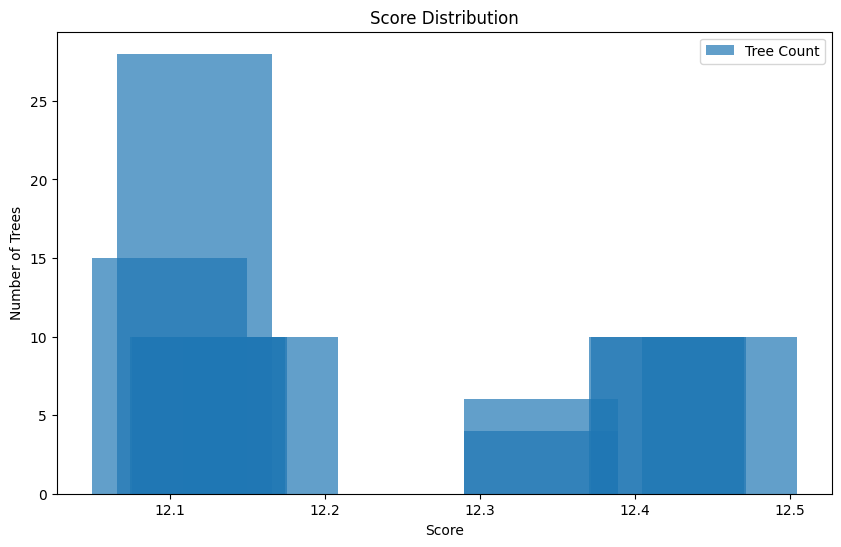

In [ ]:
file_to_plot = "1.0.json"
trees_scores = tree_score_data.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Group trees by score
grouped_trees = group_trees_by_score(trees_scores)

# Get the top K groups with the highest scores
top_k = 10  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and output tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree



Score: 12.454422, Number of Trees: 10
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
                           S                                     
  _________________________|______                                
 |     |                          S                              
 |     |          ________________|_______________                
 |     |         |         |      |               VP             
 |     |         |         |      |      _________|___            
 |     |         |         |      |     |             S          
 |     |         |         |      |     |      _______|____       
 |     |         S         |      |     |     |            VP    
 |     |      ___|___      |      |     |     |        ____|___   
 |     |     NP      VP    |      NP    |     |       |       PRT
 |     |     |       |     |      |     |     |       |        |  
 RB    IN   PRP     VBD    RB    PRP   VBD    TO      VB       RP
 |     |     |       |     | 

## 3.1 this seminar is full now, but interesting seminars are being offered next quarter too

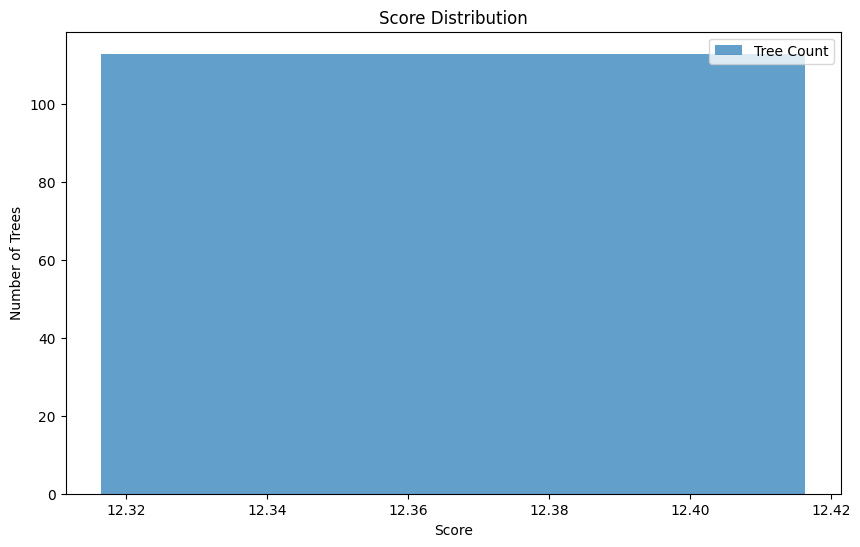

In [ ]:
file_to_plot = "1.1.json"
trees_scores = tree_score_data.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

## 3.2 I don‘t know if she is a US citizen or Green Card holder

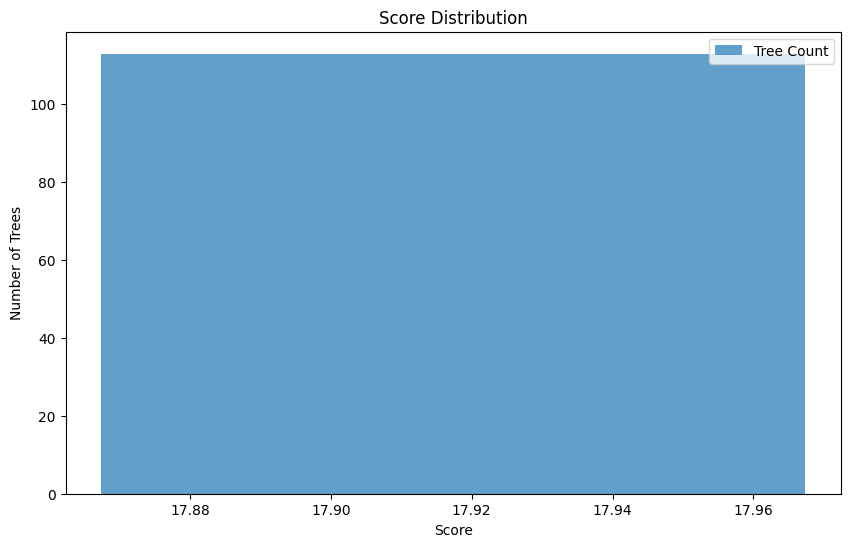

In [ ]:
file_to_plot = "1.2.json"
trees_scores = tree_score_data.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

## 3.3 He always flaunts his mother's advice to follow his own dreams

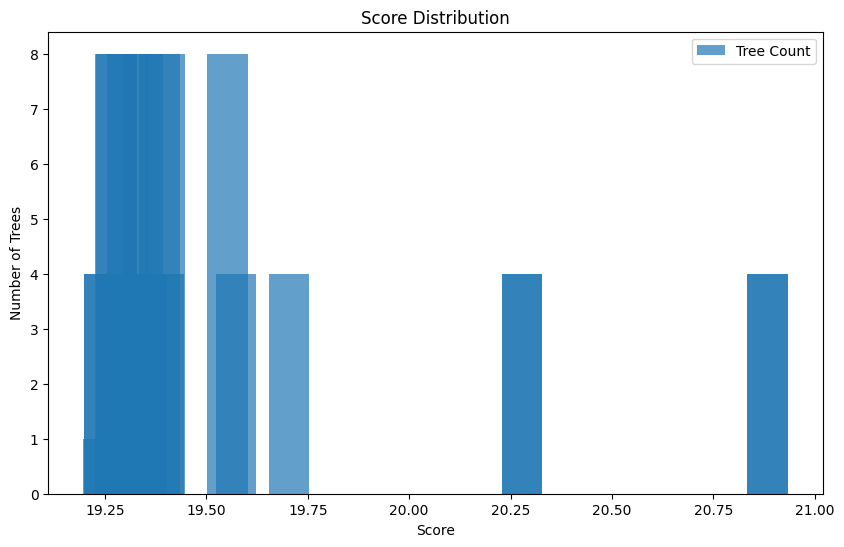

In [ ]:
file_to_plot = "1.3.json"
trees_scores = tree_score_data.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Group trees by score
grouped_trees = group_trees_by_score(trees_scores)

# Get the top K groups with the highest scores
top_k = 10  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and output tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree



Score: 20.884338, Number of Trees: 4
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
      S                                                                   
  ____|________________________                                            
 |    |                        VP                                         
 |    |        ________________|_____________                              
 |    |       |                              NP                           
 |    |       |           ___________________|__________                   
 |    |       |          |             |                S                 
 |    |       |          |             |      __________|____              
 |    |       |          |             |     |               VP           
 |    |       |          |             |     |     __________|___          
 NP  ADVP     |          NP            |     |    |              NP       
 |    |       |      ____|_____        |     |    |      _______

## 3.4 I would like to finish the book sometime this year

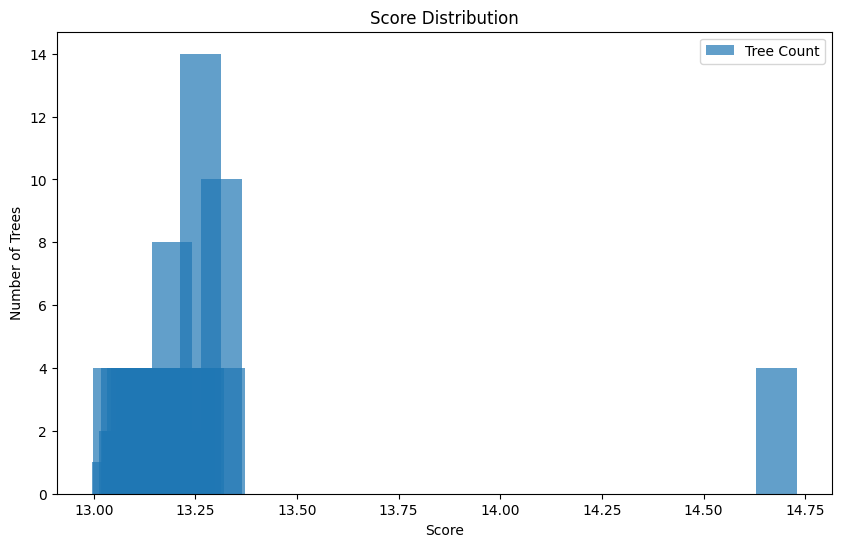

In [ ]:
file_to_plot = "1.4.json"
trees_scores = tree_score_data.get(file_to_plot)

grouped_trees = group_trees_by_score(trees_scores)
plot_score_distribution(grouped_trees)

In [ ]:
# Group trees by score
grouped_trees = group_trees_by_score(trees_scores)

# Get the top K groups with the highest scores
top_k = 10  # View the top 10 highest scoring groups
top_groups = get_top_score_groups(grouped_trees, top_k=top_k)

# Print results
for score, trees in top_groups:
    print(f"\nScore: {score:.6f}, Number of Trees: {len(trees)}")
    are_identical = compare_trees_within_group(trees)
    print(f"All Trees Identical: {'Yes' if are_identical else 'No'}")

    if not are_identical:
        print("Tree Differences:")
        for idx, tree in enumerate(trees, 1):
            print(f"\nTree {idx}:")
            print_tree(tree)  # Format and output tree structure
    else:
        print("Tree Structure:")
        print_tree(trees[0])  # Print one representative tree



Score: 14.679228, Number of Trees: 4
All Trees Identical: Yes
Tree Structure:

Formatted Tree Structure:
      S                                                  
  ____|____                                               
 |         VP                                            
 |     ____|____                                          
 |    |         VP                                       
 |    |     ____|____                                     
 |    |    |         S                                   
 |    |    |     ____|_____________                       
 |    |    |    |                  VP                    
 |    |    |    |     _____________|_____________         
 NP   |    |    |    |         NP                NP      
 |    |    |    |    |      ___|___        ______|____    
PRP   MD   VB   TO   VB    DT      NN     RB     DT   NN 
 |    |    |    |    |     |       |      |      |    |   
 I  would like  to finish the     book sometime this year




Score: 13.321

# 4. Distribution: ambigous, non-ambigous and disambigution


## 4.1 non-ambigous distribution

In [34]:
# normalize scores
def normalize_scores(scores):
    """
    Normalize scores to the range [0, 1].
    :param scores: List of scores
    :return: List of normalized scores
    """
    min_score = np.min(scores)
    max_score = np.max(scores)
    return [(score - min_score) / (max_score - min_score) if max_score > min_score else 0 for score in scores]

In [35]:
# non-ambigous
# Initialize a dictionary to store scores for each sentence
sentence_scores_no = {}

json_file = "/content/drive/MyDrive/parse/2.json"
try:
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

        # Iterate through each entry and extract scores
        for entry in data:
            sentence = entry.get("sentence", "unknown")  # Get sentence text
            scores = entry.get("scores", [])  # Get list of scores
            sentence_scores_no[sentence] = scores  # Store scores in the dictionary

        print("Successfully extracted scores for all sentences.")
except Exception as e:
    print(f"Error processing file {json_file}: {e}")

# print("\nExtracted scores for each sentence:")
# for sentence, scores in sentence_scores_no.items():
#     print(f"Sentence: {sentence}")
#     print(f"Number of scores: {len(scores)}")

# normalized_sentence_scores_no = {
#     sentence: normalize_scores(scores) for sentence, scores in sentence_scores_no.items()
# }
# std_scores_no = {sentence: np.std(scores) for sentence, scores in normalized_sentence_scores_no.items()}
# std_scores_no

Successfully extracted scores for all sentences.


In [37]:
# Sentences to remove
sentences_to_remove = [
    # "televisions are expensive these days",
    # "one of the first impressions you'll get at the airport in Delhi or Mumbai (Bombay) is the diversity of ethnic types",
    # "the colonial porte cochre sets the tone for Waikiki's most charming historic hotel, which opened in 1901",
    "what about people from uh Pennsylvania what do they think about Texans",
    "b. A lottery ticket that gives you a 10/11 chance of winning $5 million"
]

sentence_scores_non = {
    sentence: score
    for sentence, score in sentence_scores_no.items()
    if sentence not in sentences_to_remove
}

# print("\nExtracted scores for each sentence:")
# for sentence, scores in sentence_scores_non.items():
#     print(f"Sentence: {sentence}")
#     print(f"Number of scores: {len(scores)}")

normalized_sentence_scores_non = {
    sentence: normalize_scores(scores) for sentence, scores in sentence_scores_non.items()
}

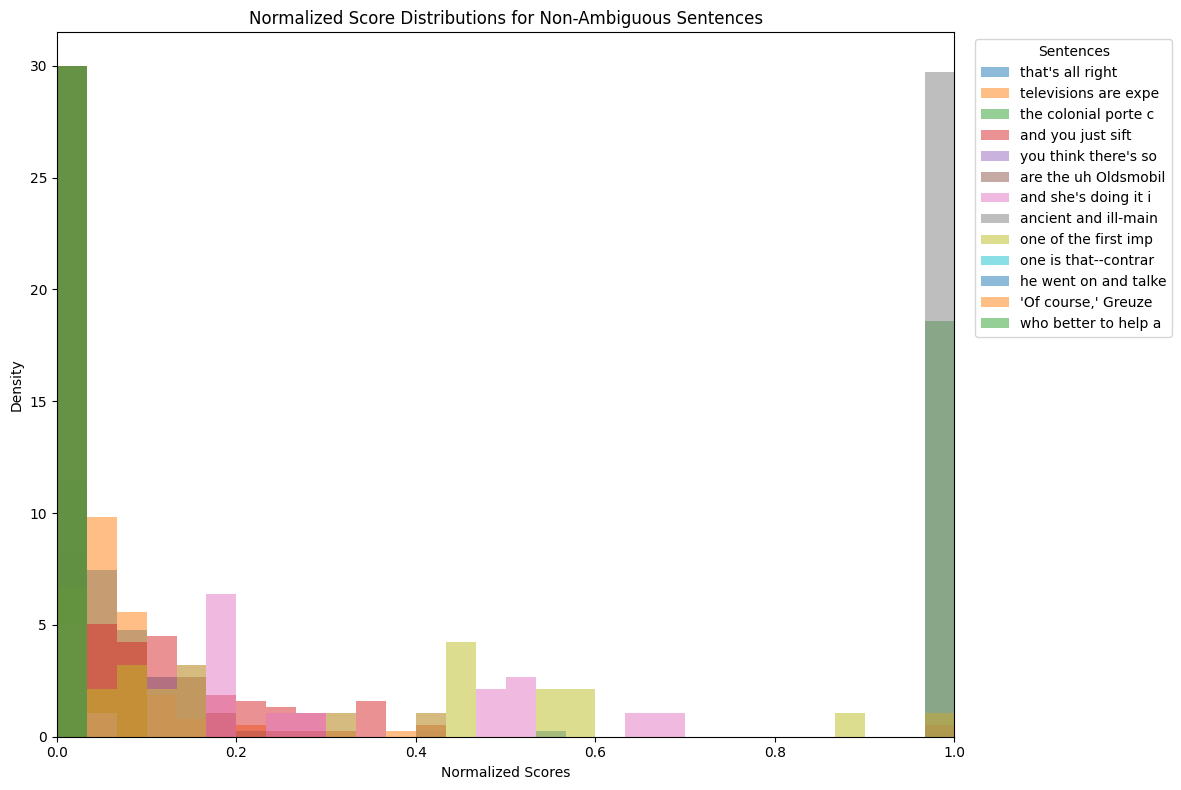

In [38]:
# Initialize the plot
plt.figure(figsize=(12, 8))

# Loop through each sentence and plot the histogram
for sentence, scores in normalized_sentence_scores_non.items():
    plt.hist(
        scores, bins=30, alpha=0.5, label=sentence[:20], density=True
    )

plt.title("Normalized Score Distributions for Non-Ambiguous Sentences")
plt.xlabel("Normalized Scores")
plt.ylabel("Density")
plt.legend(title="Sentences", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [39]:
std_scores_non = {sentence: np.std(scores) for sentence, scores in normalized_sentence_scores_non.items()}
std_scores_non

{"that's all right": 0.11726146576679654,
 'televisions are expensive these days': 0.1450255613165171,
 "the colonial porte cochre sets the tone for Waikiki's most charming historic hotel, which opened in 1901": 0.4855150839302297,
 'and you just sift': 0.15161801081868864,
 "you think there's somethin' in all that talk Topham was givin' lip to? Anse asked": 0.0,
 "are the uh Oldsmobiles that you're looking at are they the demos or they used are they new": 0.0,
 "and she's doing it i mean it's not like it's like": 0.23879106751029466,
 'ancient and ill-maintained, it starts off shiny and gets rapidly creakier as it approaches the border': 0.0936549136660032,
 "one of the first impressions you'll get at the airport in Delhi or Mumbai (Bombay) is the diversity of ethnic types": 0.27400190142384456,
 "one is that--contrary to the opinion of virtually everyone else in the world--AIDS in fact hasn't reduced gay males' life expectancy by that much--a few years, at most": 0.0,
 'he went on an

## 4.2 ambigous distribution

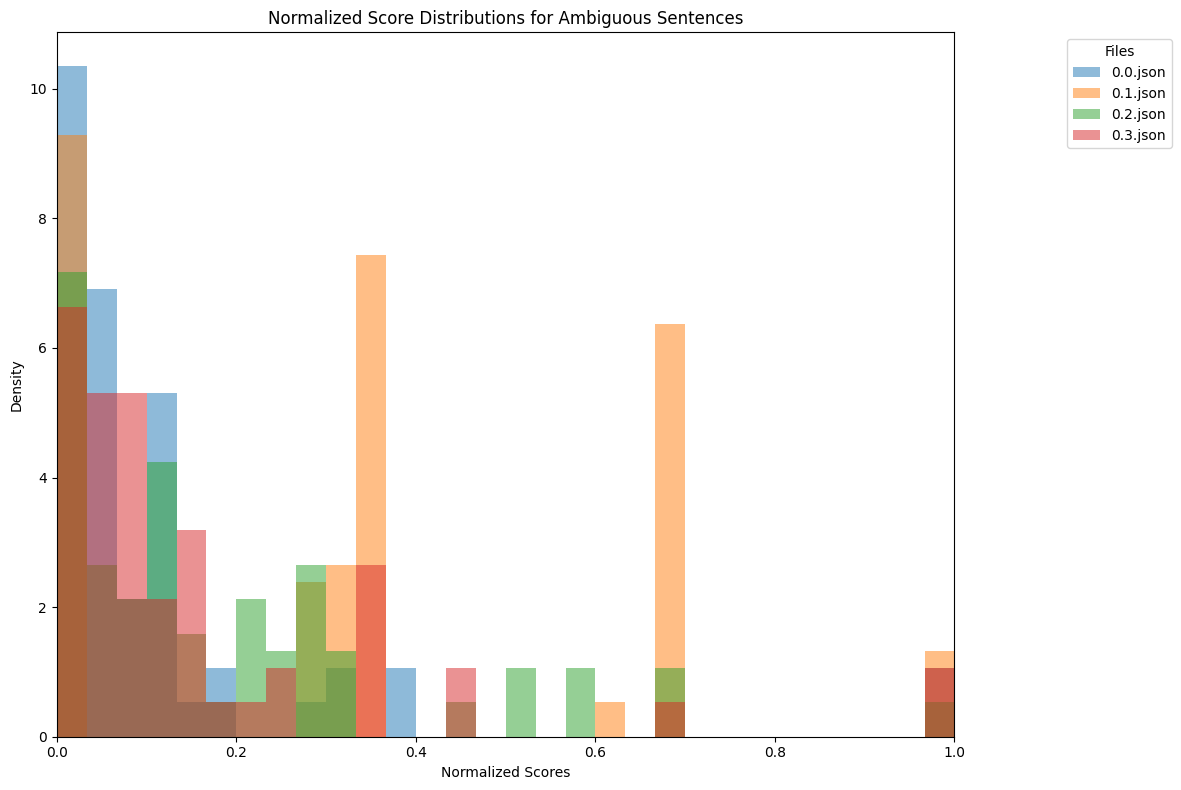

In [28]:
# ambigous
files_to_plot = ["0.0.json", "0.1.json", "0.2.json", "0.3.json"]

file_scores = {}
# Extract scores
for file_name in files_to_plot:
    if file_name in tree_score_data_0:
        scores = [score for _, score in tree_score_data_0[file_name]]
        file_scores[file_name] = scores
    else:
        print(f"File {file_name} not found in tree_score_data_0.")

# Normalize scores
normalized_sentence_scores_ambiguous = {
    file_name: [
        (score - min(scores)) / (max(scores) - min(scores)) if max(scores) > min(scores) else 0
        for score in scores
    ]
    for file_name, scores in file_scores.items()
}

# Plot the distribution of normalized scores
plt.figure(figsize=(12, 8))
for file_name, scores in normalized_sentence_scores_ambiguous.items():
    plt.hist(scores, bins=30, alpha=0.5, label=file_name, density=True)

plt.title("Normalized Score Distributions for Ambiguous Sentences")
plt.xlabel("Normalized Scores")
plt.ylabel("Density")
plt.legend(title="Files", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [29]:
std_scores_ambigous = {sentence: np.std(scores) for sentence, scores in normalized_sentence_scores_ambiguous.items()}
std_scores_ambigous

{'0.0.json': 0.19169204178390892,
 '0.1.json': 0.2860401097296736,
 '0.2.json': 0.20789219847496435,
 '0.3.json': 0.21080462212585432}

## 4.3 ambiguous after disambiguation distribution

In [40]:
# Initialize a dictionary to store (tree, score) pairs for each file
tree_score_data_1 = {}

file_names = [
    "/content/drive/MyDrive/parse/0.0.1.json",
    "/content/drive/MyDrive/parse/0.1.1.json",
    "/content/drive/MyDrive/parse/0.2.1.json",
    "/content/drive/MyDrive/parse/0.3.1.json"
]

# Iterate through files and extract data
for json_file in json_files:
    file_name = json_file.split("/")[-1]  # Get the file name
    print(f"Processing file: {file_name}...")
    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            data = json.load(file)
            if isinstance(data, list) and 'trees' in data[0]:  # Ensure correct data format
                tree_score_data_1[file_name] = [
                    (entry['structure'], entry['score']) for entry in data[0]['trees']
                ]
                print(f"Successfully extracted {len(tree_score_data_1[file_name])} (tree, score) pairs from {file_name}.")
            else:
                print(f"No 'trees' found in {file_name}.")
                tree_score_data_1[file_name] = []
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        tree_score_data_1[file_name] = []


Processing file: 0.0.1.json...
Successfully extracted 113 (tree, score) pairs from 0.0.1.json.
Processing file: 0.1.1.json...
Successfully extracted 113 (tree, score) pairs from 0.1.1.json.
Processing file: 0.2.1.json...
Successfully extracted 113 (tree, score) pairs from 0.2.1.json.
Processing file: 0.3.1.json...
Successfully extracted 113 (tree, score) pairs from 0.3.1.json.


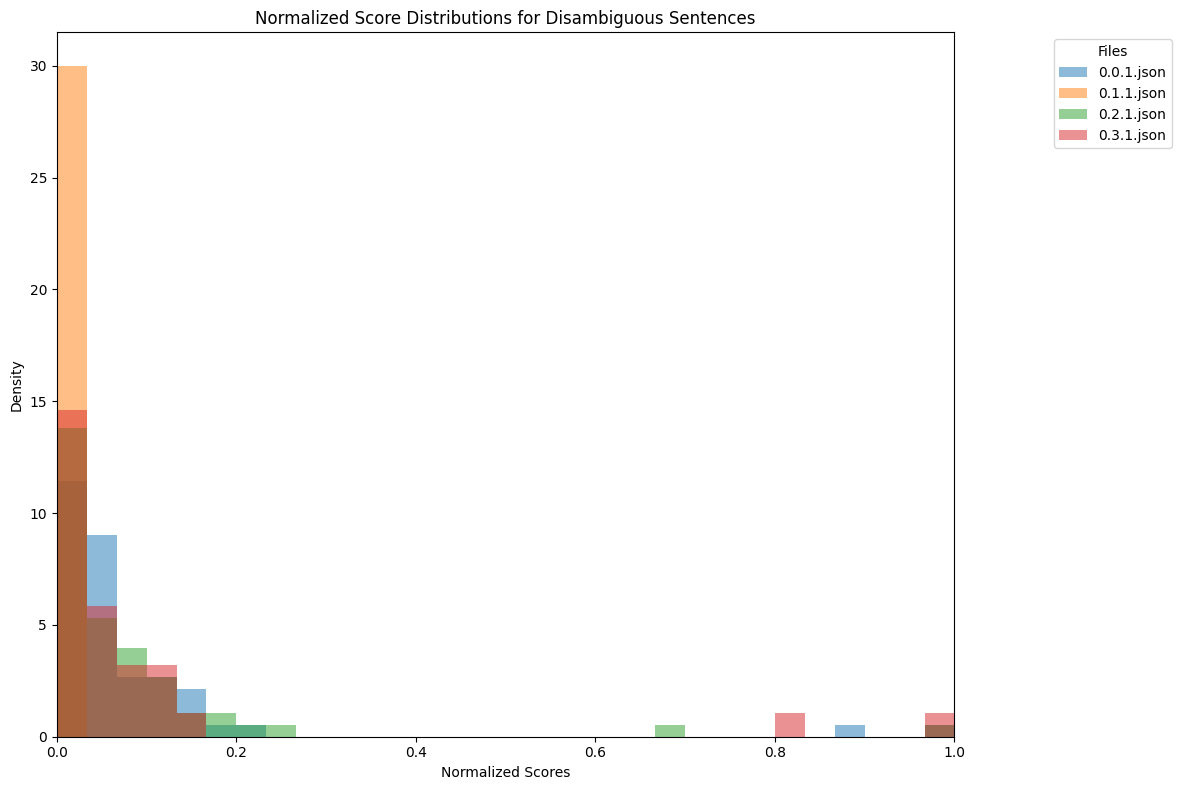

In [47]:
# after disambiguous
files_to_plot = ["0.0.1.json", "0.1.1.json", "0.2.1.json", "0.3.1.json"]

file_scores = {}
# Extract scores
for file_name in files_to_plot:
    if file_name in tree_score_data_1:  # Ensure tree_score_data_1 is used for "after ambiguous"
        scores = [score for _, score in tree_score_data_1[file_name]]
        file_scores[file_name] = scores
    else:
        print(f"File {file_name} not found in tree_score_data_1.")

# Normalize scores
normalized_sentence_scores_after_ambiguous = {
    file_name: [
        (score - min(scores)) / (max(scores) - min(scores)) if max(scores) > min(scores) else 0
        for score in scores
    ]
    for file_name, scores in file_scores.items()
}

# Plot the distribution of normalized scores
plt.figure(figsize=(12, 8))

for file_name, scores in normalized_sentence_scores_after_ambiguous.items():
    plt.hist(scores, bins=30, alpha=0.5, label=file_name, density=True)

plt.title("Normalized Score Distributions for Disambiguous Sentences")
plt.xlabel("Normalized Scores")
plt.ylabel("Density")
plt.legend(title="Files", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [42]:
std_scores_disambigous = {sentence: np.std(scores) for sentence, scores in normalized_sentence_scores_after_ambiguous.items()}
std_scores_disambigous

{'0.0.1.json': 0.17139721896156906,
 '0.1.1.json': 0.0,
 '0.2.1.json': 0.15771140895732183,
 '0.3.1.json': 0.22619294197183212}

#5. between ambiguous and disambigution

## **5.1** std


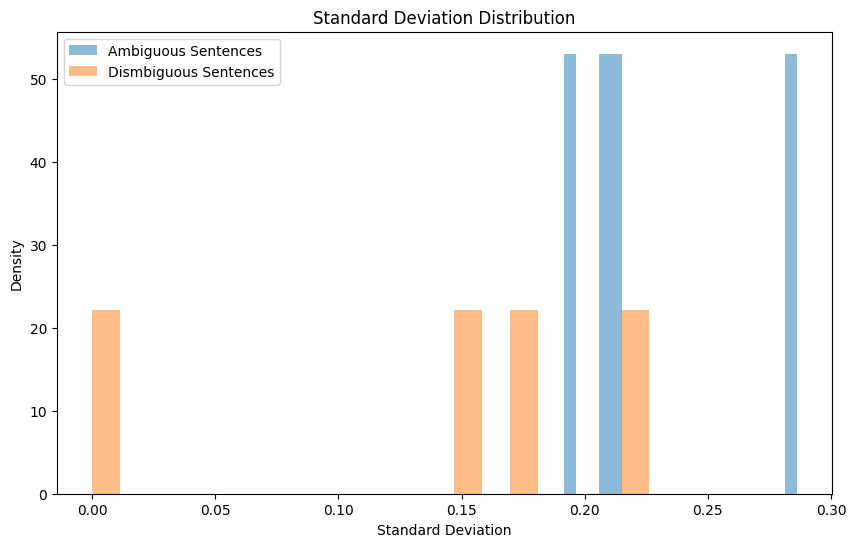

In [49]:
ambiguous_std = list(std_scores_ambigous.values())
disambiguous_std = list(std_scores_disambigous.values())

plt.figure(figsize=(10, 6))
plt.hist(ambiguous_std, bins=20, alpha=0.5, label="Ambiguous Sentences", density=True)
plt.hist(disambiguous_std, bins=20, alpha=0.5, label="Dismbiguous Sentences", density=True)
plt.title("Standard Deviation Distribution")
plt.xlabel("Standard Deviation")
plt.ylabel("Density")
plt.legend()
plt.show()

<ipython-input-50-b84666d14aea>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambiguous_std, shade=True, label="Ambiguous Sentences", fill=True, alpha=0.5)
<ipython-input-50-b84666d14aea>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(disambiguous_std, shade=True, label="DIsmbiguous Sentences", fill=True, alpha=0.5)


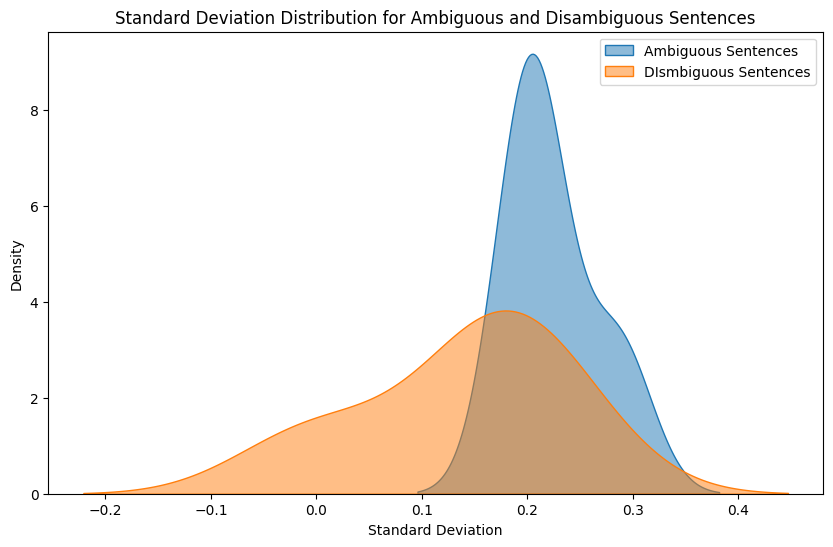

In [50]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ambiguous_std, shade=True, label="Ambiguous Sentences", fill=True, alpha=0.5)
sns.kdeplot(disambiguous_std, shade=True, label="DIsmbiguous Sentences", fill=True, alpha=0.5)
plt.title("Standard Deviation Distribution for Ambiguous and Disambiguous Sentences")
plt.xlabel("Standard Deviation")
plt.ylabel("Density")
plt.legend()
plt.show()

In [52]:
print("Ambiguous Sentences:")
print(f"Mean: {np.mean(ambiguous_std):.4f}, Std Dev: {np.std(ambiguous_std):.4f}")

print("Non-Ambiguous Sentences:")
print(f"Mean: {np.mean(disambiguous_std):.4f}, Std Dev: {np.std(disambiguous_std):.4f}")

Ambiguous Sentences:
Mean: 0.2241, Std Dev: 0.0365
Non-Ambiguous Sentences:
Mean: 0.1388, Std Dev: 0.0841


In [54]:
print("Variance of Ambiguous Sentences:", np.var(ambiguous_std))
print("Variance of Non-Ambiguous Sentences:", np.var(disambiguous_std))

Variance of Ambiguous Sentences: 0.0013315781605763317
Variance of Non-Ambiguous Sentences: 0.0070807959500402235


In [55]:
from scipy.stats import ttest_ind

# Perform independent sample t-test
t_stat, p_value = ttest_ind(ambiguous_std, disambiguous_std, equal_var=False)

print("Independent t-test:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Determine significance of the result
if p_value < 0.05:
    print("The difference between the two distributions is statistically significant (p < 0.05).")
else:
    print("The difference between the two distributions is NOT statistically significant (p >= 0.05).")

Independent t-test:
T-statistic: 1.6105
P-value: 0.1810
The difference between the two distributions is NOT statistically significant (p >= 0.05).


#6. between ambiguous and non-ambiguous

## **6.1** std


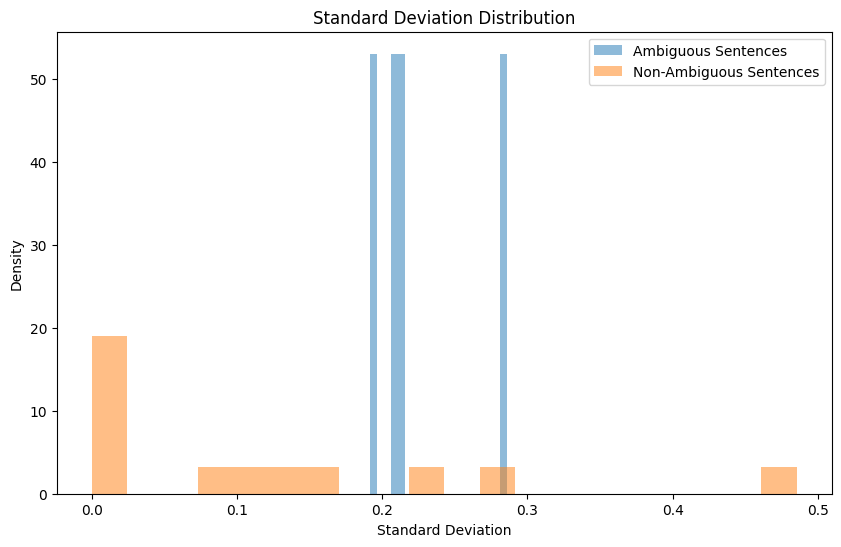

In [109]:
ambiguous_std = list(std_scores_ambigous.values())
non_ambiguous_std = list(std_scores_non.values())

plt.figure(figsize=(10, 6))
plt.hist(ambiguous_std, bins=20, alpha=0.5, label="Ambiguous Sentences", density=True)
plt.hist(non_ambiguous_std, bins=20, alpha=0.5, label="Non-Ambiguous Sentences", density=True)
plt.title("Standard Deviation Distribution")
plt.xlabel("Standard Deviation")
plt.ylabel("Density")
plt.legend()
plt.show()

<ipython-input-110-d8bcacf69d94>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ambiguous_std, shade=True, label="Ambiguous Sentences", fill=True, alpha=0.5)
<ipython-input-110-d8bcacf69d94>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_ambiguous_std, shade=True, label="Non-Ambiguous Sentences", fill=True, alpha=0.5)


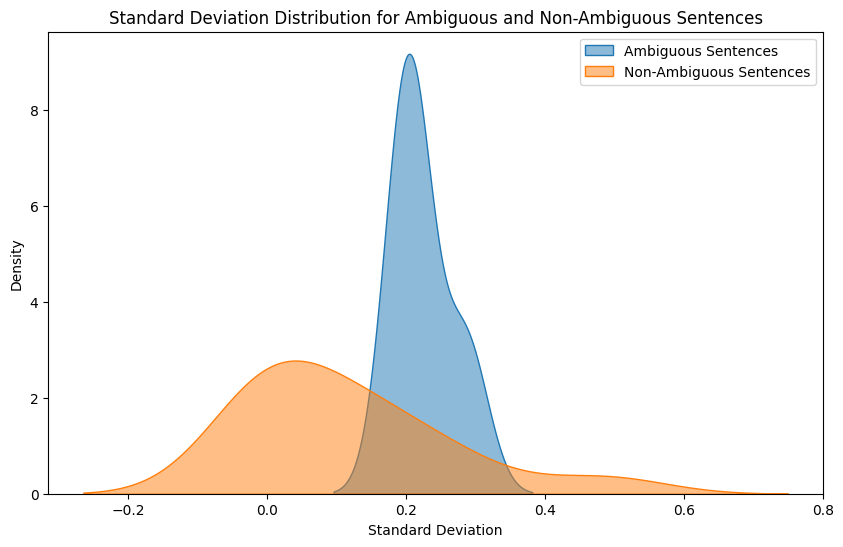

In [110]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ambiguous_std, shade=True, label="Ambiguous Sentences", fill=True, alpha=0.5)
sns.kdeplot(non_ambiguous_std, shade=True, label="Non-Ambiguous Sentences", fill=True, alpha=0.5)
plt.title("Standard Deviation Distribution for Ambiguous and Non-Ambiguous Sentences")
plt.xlabel("Standard Deviation")
plt.ylabel("Density")
plt.legend()
plt.show()

In [111]:
print("Ambiguous Sentences:")
print(f"Mean: {np.mean(ambiguous_std):.4f}, Std Dev: {np.std(ambiguous_std):.4f}")

print("Non-Ambiguous Sentences:")
print(f"Mean: {np.mean(non_ambiguous_std):.4f}, Std Dev: {np.std(non_ambiguous_std):.4f}")

Ambiguous Sentences:
Mean: 0.2241, Std Dev: 0.0365
Non-Ambiguous Sentences:
Mean: 0.1158, Std Dev: 0.1414


In [112]:
print("Variance of Ambiguous Sentences:", np.var(ambiguous_std))
print("Variance of Non-Ambiguous Sentences:", np.var(non_ambiguous_std))

Variance of Ambiguous Sentences: 0.0013315781605763317
Variance of Non-Ambiguous Sentences: 0.019994716523296943


In [113]:
from scipy.stats import ttest_ind

# Perform independent sample t-test
t_stat, p_value = ttest_ind(ambiguous_std, non_ambiguous_std, equal_var=False)

print("Independent t-test:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Determine significance of the result
if p_value < 0.05:
    print("The difference between the two distributions is statistically significant (p < 0.05).")
else:
    print("The difference between the two distributions is NOT statistically significant (p >= 0.05).")

Independent t-test:
T-statistic: 2.3570
P-value: 0.0324
The difference between the two distributions is statistically significant (p < 0.05).


In [114]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(ambiguous_std, non_ambiguous_std, alternative='two-sided')

print("Mann-Whitney U-test:")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Determine significance of the result
if p_value < 0.05:
    print("The difference between the two distributions is statistically significant (p < 0.05).")
else:
    print("The difference between the two distributions is NOT statistically significant (p >= 0.05).")

Mann-Whitney U-test:
U-statistic: 42.0000
P-value: 0.0728
The difference between the two distributions is NOT statistically significant (p >= 0.05).


## 6.2 entropy

In [115]:
from scipy.stats import entropy

def calculate_entropy(scores):
    """
    Calculate the entropy of a distribution.
    :param scores: List of normalized scores
    :return: Entropy value
    """
    hist, _ = np.histogram(scores, bins=30, density=True)
    hist = hist / hist.sum()  # Convert to a probability distribution
    return entropy(hist)

# Calculate entropy for each sentence
ambiguous_entropy = {sentence: calculate_entropy(scores) for sentence, scores in normalized_sentence_scores_ambiguous.items()}
non_ambiguous_entropy = {sentence: calculate_entropy(scores) for sentence, scores in normalized_sentence_scores_non.items()}

print(ambiguous_entropy)
print(non_ambiguous_entropy)


{'0.0.json': 1.8150613541787892, '0.1.json': 1.663259000883644, '0.2.json': 2.423749475161727, '0.3.json': 2.155919986486693}
{"that's all right": 1.8023501196040799, 'televisions are expensive these days': 1.8016019272406727, "the colonial porte cochre sets the tone for Waikiki's most charming historic hotel, which opened in 1901": 0.6643234654532404, 'and you just sift': 2.2936677303580075, "you think there's somethin' in all that talk Topham was givin' lip to? Anse asked": 0.0, "are the uh Oldsmobiles that you're looking at are they the demos or they used are they new": 0.0, "and she's doing it i mean it's not like it's like": 2.4026546551493015, 'ancient and ill-maintained, it starts off shiny and gets rapidly creakier as it approaches the border': 0.05064557459684864, "one of the first impressions you'll get at the airport in Delhi or Mumbai (Bombay) is the diversity of ethnic types": 2.3097425631006017, "one is that--contrary to the opinion of virtually everyone else in the world

In [116]:
# Extract entropy values
ambig_entropy_values = list(ambiguous_entropy.values())
non_ambig_entropy_values = list(non_ambiguous_entropy.values())

# Compute mean and standard deviation
ambig_mean, ambig_std = np.mean(ambig_entropy_values), np.std(ambig_entropy_values)
non_ambig_mean, non_ambig_std = np.mean(non_ambig_entropy_values), np.std(non_ambig_entropy_values)

print(f"Ambiguous Sentences - Mean: {ambig_mean:.4f}, Std: {ambig_std:.4f}")
print(f"Non-Ambiguous Sentences - Mean: {non_ambig_mean:.4f}, Std: {non_ambig_std:.4f}")

Ambiguous Sentences - Mean: 2.0145, Std: 0.2961
Non-Ambiguous Sentences - Mean: 0.8712, Std: 1.0168


In [117]:
from scipy.stats import ttest_ind, mannwhitneyu

# Perform t-test
t_stat, p_value_t = ttest_ind(ambig_entropy_values, non_ambig_entropy_values, equal_var=False)
print(f"T-Test - T-Statistic: {t_stat:.4f}, P-Value: {p_value_t:.4f}")

# Perform Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(ambig_entropy_values, non_ambig_entropy_values, alternative='two-sided')
print(f"Mann-Whitney U-Test - U-Statistic: {u_stat:.4f}, P-Value: {p_value_u:.4f}")

T-Test - T-Statistic: 3.3660, P-Value: 0.0043
Mann-Whitney U-Test - U-Statistic: 41.0000, P-Value: 0.0933


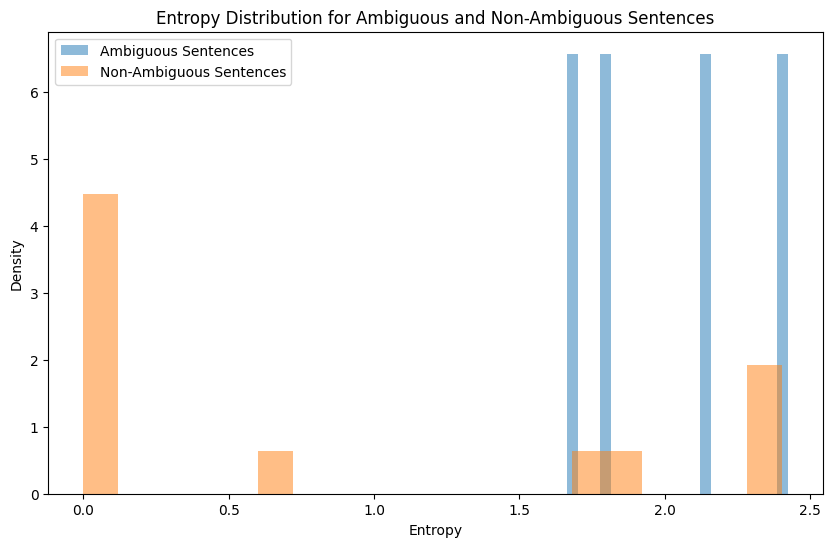

In [118]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(ambig_entropy_values, bins=20, alpha=0.5, label="Ambiguous Sentences", density=True)
plt.hist(non_ambig_entropy_values, bins=20, alpha=0.5, label="Non-Ambiguous Sentences", density=True)
plt.title("Entropy Distribution for Ambiguous and Non-Ambiguous Sentences")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()
plt.show()

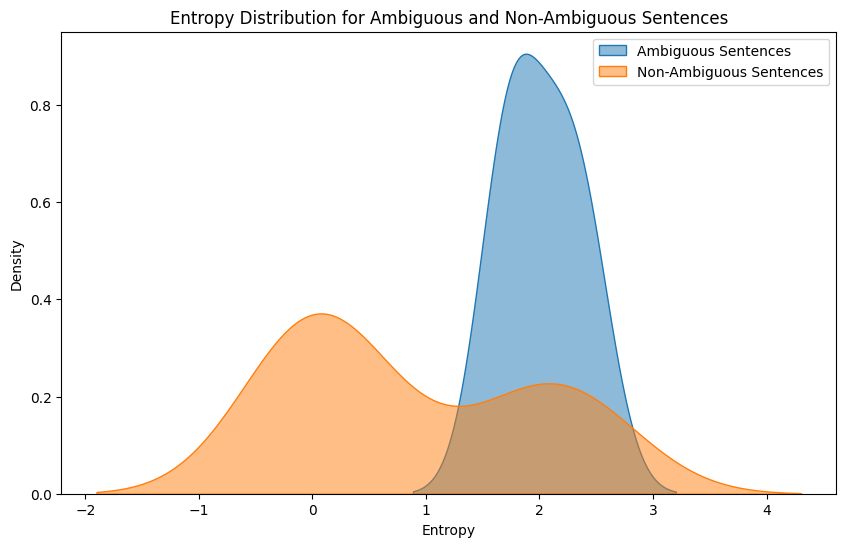

In [119]:
# Plot KDE for entropy values
plt.figure(figsize=(10, 6))
sns.kdeplot(ambig_entropy_values, label="Ambiguous Sentences", fill=True, alpha=0.5)
sns.kdeplot(non_ambig_entropy_values, label="Non-Ambiguous Sentences", fill=True, alpha=0.5)
plt.title("Entropy Distribution for Ambiguous and Non-Ambiguous Sentences")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.legend()
plt.show()

## 6.3 Divergence

In [120]:
# Calculate histograms
ambig_hist, _ = np.histogram(ambig_entropy_values, bins=20, density=True)
non_ambig_hist, _ = np.histogram(non_ambig_entropy_values, bins=20, density=True)

# Prevent zero-value issues
ambig_hist += 1e-10
non_ambig_hist += 1e-10

# Normalize to probability distributions
ambig_hist /= ambig_hist.sum()
non_ambig_hist /= non_ambig_hist.sum()

# Compute JS divergence
js_divergence = jensenshannon(ambig_hist, non_ambig_hist)
print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

# Compute KL divergence
kl_divergence = entropy(ambig_hist, non_ambig_hist)
print(f"KL Divergence: {kl_divergence:.4f}")

Jensen-Shannon Divergence: 0.5296
KL Divergence: 11.7076
